**тематическое моделирование**

_Евгений Борисов <esborisov@sevsu.ru>_

In [1]:
# http://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

# разложение частотной матрицы [ слова x документы ]  
#
# получаем матрицу с описанием тем [ слова х темы ]   
# и матрицу вероятностей событий "тема описывает документ"  [ темы х документы ]
# 
# [ слова x документы ] = [ слова х темы ] * [ темы х документы ]
# 
# p(w|d) = p(w|t) * p(t|d)

## библиотеки

In [2]:
import re
# import gzip
import numpy as np
import numpy.random as rng
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

np.set_printoptions(precision=2) # вывод на печать чисел до 2 знака
pd.options.display.max_colwidth = 200 

tqdm.pandas()

In [3]:
from sklearn import __version__ as SKLEARN_VERSION

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

SKLEARN_VERSION

'1.1.2'

## тексты

In [4]:
data = pd.read_pickle('../data/news.pkl.gz')
print('текстов:',len(data))
data.sample(4)

текстов: 3196


,text,tag
3155,"ИТАР-ТАСС. Новости культуры (оперативная лента) На Чукотке открылся фестиваль\nморских охотников ""Берингия"" Культурно- спортивный фестиваль морских охотников\n""Берингия"" открылся сегодня в чукотск...",culture
1060,От 5 до 50%. Где минчанам искать скидки в декабре\n\n29 ноября 2016 в 14:39\n\nFINANCE.TUT.BY\n\nСтоличные универмаги и торговые сети в декабре будут часто предоставлять скидки на товары. Об акция...,economics
664,Грандиозная распродажа Hyundai Accent и Hyundai Creta!\n\n1 декабря 2016 в 9:00\n\n*На правах рекламы\n\nСегодня официально объявлена зима и открыт сезон предновогодних распродаж автомобилей Hyund...,reclama
2704,"Минпромторг России выдал 150 миллионов отечественной компании «Т-Платформе» для разработки влагозащищенных и противоударных ноутбуков. Аппараты станут функционировать на базе процессора Intel, пиш...",tech


## токенизация и очистка

In [5]:
# применяет список замен pat к строке s
def replace_patterns(s,pat):
    if len(pat)<1: return s
    return  replace_patterns( re.sub(pat[0][0],pat[0][1],s), pat[1:] )

# нормализация текста
def string_normalizer(s):
    pat = [
       [r'ё','е'] # замена ё для унификации
       ,[r'</?[a-z]+>',' '] # удаляем xml
       ,[r'[^a-zа-я\- ]+',' '] # оставляем только буквы, пробел и -
       ,[r' -\w+',' '] # удаляем '-й','-тый' и т.п.
       ,[r'\w+- ',' ']
       ,[r' +',' '] # удаляем повторы пробелов
    ]
    return replace_patterns(s.lower(),pat).strip()

In [6]:
# def string_normalizer(s): 
#     return re.sub(r'[\W]+',' ',s.lower().replace('ё','е'))

In [7]:
data['ctext'] = data['text'].progress_apply(string_normalizer)

  0%|          | 0/3196 [00:00<?, ?it/s]

In [8]:
data.sample(3)

,text,tag,ctext
976,"Умер директор департамента безопасности Беларусбанка\n\n5 декабря 2016 в 11:41\n\nTUT.BY\n\nНа 63-м году жизни скончался генерал-майор милиции в отставке, директор департамента безопасности Белару...",economics,умер директор департамента безопасности беларусбанка декабря в tut by на году жизни скончался генерал-майор милиции в отставке директор департамента безопасности беларусбанка иван сергей информаци...
37,Футбол : Николаю Толстых предложили перейти на другую работу Многолетний\nпредводитель первого и второго дивизионов футбольного чемпионата страны\nНиколай Толстых переизбран главой Профессионально...,sport,футбол николаю толстых предложили перейти на другую работу многолетний предводитель первого и второго дивизионов футбольного чемпионата страны николай толстых переизбран главой профессиональной фу...
2994,"Японская автомобильная компания Mitsubishi начала процесс тестирования своего нового кроссвэна. Стоит отметить, что главной площадкой продаж станет индонезийский автомобильный рынок.\n\nОб этом ст...",auto,японская автомобильная компания mitsubishi начала процесс тестирования своего нового кроссвэна стоит отметить что главной площадкой продаж станет индонезийский автомобильный рынок об этом стало из...


## модели

In [9]:
def print_top_words(model, feature_names, n_top_words=7):
    for topic_idx, topic in enumerate(model.components_):
        message = "Тема %d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

In [10]:
n_features = 1000
n_components = 10

### CountVectorizer + LatentDirichletAllocation

In [11]:
from nltk.corpus import stopwords as nltk_stopwords

stopwords = set(nltk_stopwords.words('russian'))

# разрезаем стоки на слова, выкидываем stopwords, выполняем стеминг
def tokenizer(s,stopwords=stopwords): 
    for w in s.split(' '):
        if len(w)<2: continue
        if w in stopwords: continue
        yield w        
    return ''

In [12]:
%%time

# tf features 
tf_vectorizer = CountVectorizer( 
        max_df=.95, 
        min_df=2, 
        max_features=n_features,
        tokenizer=tokenizer, 
        token_pattern=None,
    )
tf = tf_vectorizer.fit_transform(data['ctext'])
tf_feature_names = tf_vectorizer.get_feature_names_out()

# LDA - латентное размещение Дирихле
lda = LatentDirichletAllocation( 
        n_components=n_components, 
        max_iter=5,
        learning_method='online', 
        learning_offset=50.,
        random_state=0, 
    ).fit(tf)

print('\nLDA:\n')
print_top_words(lda, tf_feature_names)


LDA:

Тема 0: компания компании сети apple пользователей фото рынке
Тема 1: ученые коми путин ссср университета японии также
Тема 2: автомобиль дтп автомобилей результате км водитель автомобиля
Тема 3: мяч фильм лучший динамо матче получил очков
Тема 4: рублей народов млн коренных севера года малочисленных
Тема 5: это очень которые лет время года году
Тема 6: by tut декабря фото ноября внимание установлена
Тема 7: года декабря также россии мира году время
Тема 8: россии заявил беларуси декабря президента глава также
Тема 9: года сша декабря россии трамп ранее сообщает
CPU times: user 3.76 s, sys: 0 ns, total: 3.76 s
Wall time: 3.77 s


In [17]:
# LDA:

# Тема 0: на что по его года также как
# Тема 1: версия вас или не установлена браузер ваш
# Тема 2: object динамо украины sport на матча 14
# Тема 3: на до по декабря 00 рублей by
# Тема 4: на мяч чемпионата матче лучший команды сборной
# Тема 5: на что не будет для от при
# Тема 6: на года за из по году 2016
# Тема 7: народов коренных севера малочисленных края коми руб
# Тема 8: не на что но это как из
# Тема 9: по на из что за декабря не

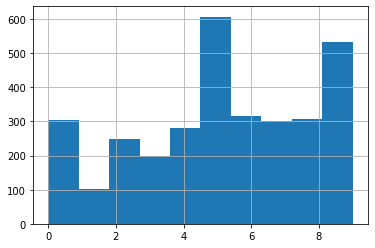

In [18]:
t = np.argmax(lda.transform(tf),axis=1) 
plt.hist(t)
plt.grid()

### TfidfVectorizer + NMF (Frobenius norm)

In [30]:
# tf-idf features 
tfidf_vectorizer = TfidfVectorizer( 
    max_df=.95, 
    min_df=2, 
    max_features=n_features,
    tokenizer=tokenizer, 
    token_pattern=None,)

tfidf = tfidf_vectorizer.fit_transform(data['ctext'])
tfidf_feature_names = tf_vectorizer.get_feature_names_out()

# NMF (Frobenius norm) - неотрицательное матричное разложение
nmf = NMF( n_components=n_components, random_state=1, l1_ratio=.5 ).fit(tfidf)

print('\nNMF:\n')
print_top_words( nmf, tfidf_feature_names )


NMF:

Тема 0: это by tut беларуси очень декабря фото
Тема 1: трамп сша трампа дональд президент избранный президента
Тема 2: дтп водитель области результате мвд декабря происшествия
Тема 3: flash adobe javascript player проигрывателя html отключен
Тема 4: савченко украины партии надежда заявила лидер действия
Тема 5: народов севера коренных малочисленных края июля фестиваль
Тема 6: ученые университета специалисты могут часов исследования людей
Тема 7: рублей года компания млн компании году млрд
Тема 8: россии путин рф заявил россия глава алеппо
Тема 9: динамо матче чемпионата мира стал очков лучшим


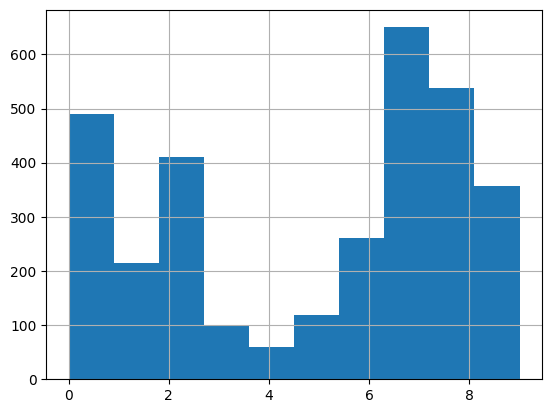

In [31]:
t = np.argmax(nmf.transform(tfidf),axis=1) 
plt.hist(t)
plt.grid()

In [35]:
# data['topic_id'] = np.argmax( nmf.transform( tfidf_vectorizer.transform(data['ctext']) ) ,axis=1)
# data.sample(5)

### TfidfVectorizer + NMF (generalized Kullback-Leibler divergence)

In [36]:
# tf-idf features 
tfidf_vectorizer = TfidfVectorizer( 
    max_df=.95, 
    min_df=2, 
    max_features=n_features, 
    tokenizer=tokenizer, 
    token_pattern=None,)

tfidf = tfidf_vectorizer.fit_transform(data['ctext'])
tfidf_feature_names = tf_vectorizer.get_feature_names_out()

# NMF (generalized Kullback-Leibler divergence) 
nmf = NMF( n_components=n_components, random_state=1, beta_loss='kullback-leibler', 
          solver='mu', max_iter=1000,  l1_ratio=.5 ).fit(tfidf)

print('\nNMF:\n')
print_top_words( nmf, tfidf_feature_names )


NMF:

Тема 0: это очень лет которые просто время поэтому
Тема 1: сша трамп президент трампа президента пост дональд
Тема 2: дтп области водитель результате мвд декабря мчс
Тема 3: by tut беларуси декабря видео фото беларусь
Тема 4: савченко россии заявил украины россия глава путин
Тема 5: рублей млн народов севера евро коренных области
Тема 6: ученые специалисты людей могут часов университета человека
Тема 7: компания компании долларов года модели рублей автомобиль
Тема 8: новости риа сообщает алеппо города передает говорится
Тема 9: мира динамо стал чемпионата лучший матче лучшим


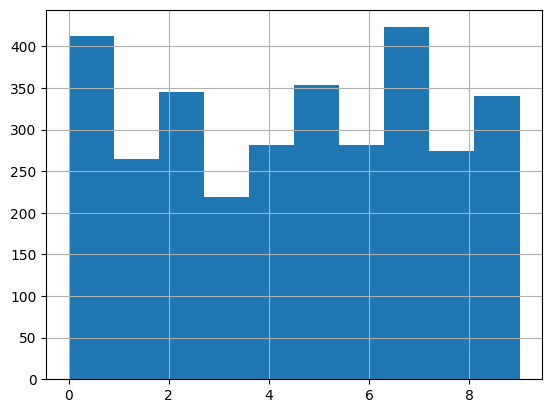

In [37]:
t = np.argmax(nmf.transform(tfidf),axis=1) 
plt.hist(t)
plt.grid()

In [38]:
data['topic_id'] = np.argmax( nmf.transform( tfidf_vectorizer.transform(data['ctext']) ) ,axis=1)
data.sample(5)

,text,tag,ctext,topic_id
2954,"Как сообщают некоторые автомобильные аналитики, которые проанализировали российский рынок автомобилей, самой популярной моделью с автоматической коробкой передач является Toyota Camry . Дело в том...",auto,как сообщают некоторые автомобильные аналитики которые проанализировали российский рынок автомобилей самой популярной моделью с автоматической коробкой передач является toyota camry дело в том что...,7
1912,"МОСКВА, 12 дек – РИА Новости. Ночью в атмосфере экзопланеты HAT-P-7 b идут дожди, ""капли"" в которых представляют собой кристаллы рубинов и сапфиров, говорится в статье, опубликованной в журнале Na...",science,москва дек риа новости ночью в атмосфере экзопланеты hat- b идут дожди капли в которых представляют собой кристаллы рубинов и сапфиров говорится в статье опубликованной в журнале nature astronomy ...,6
2395,"Всероссийский конкурс юных талантов\n\n""Ведь это очень вредно – не ехать на бал,\n\nкогда ты этого заслуживаешь!""\n\nЕвгений Шварц. ""Золушка""\n\nМы открываем второй сезон!\n\nУстраивайтесь у экран...",culture,всероссийский конкурс юных талантов ведь это очень вредно не ехать на бал когда ты этого заслуживаешь евгений шварц золушка мы открываем второй сезон устраивайтесь у экрана всей семьей участвуйте ...,0
1918,Обама присмотрел себе офис во Всемирном фонде дикой природы\n\nОдин из офисов в вашингтонской штаб-квартире Всемирного фонда дикой природы (WWF) будет арендовать уходящий президент Соединенных шта...,politics,обама присмотрел себе офис во всемирном фонде дикой природы один из офисов в вашингтонской штаб-квартире всемирного фонда дикой природы wwf будет арендовать уходящий президент соединенных штатов а...,1
3188,"Fishery (fishery.ru) (Владивосток) Традиционный промысел обеспечили треской\nПредставители коренных малочисленных народов, проживающие на территории\nМурманской области, получили квоты на вылов тр...",social,fishery fishery ru владивосток традиционный промысел обеспечили треской представители коренных малочисленных народов проживающие на территории мурманской области получили квоты на вылов трески и п...,5
